In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Loading Data/Creating Columns

In [2]:
donations = pd.read_csv(r"/work/Donations.csv")
donations

,giftid,GiftDate,DonationAmount,gifttype,id
0,11,8/31/2021,26.06,Credit,dcd42c1daa7536b608107306772f3f17
1,12,8/31/2021,10.60,Credit,45e564e8efa94ffe97fcb67b018000d5
2,12,8/31/2021,10.60,Credit,45e564e8efa94ffe97fcb67b018000d5
3,12,8/31/2021,10.60,Credit,04fb1f4fc42ac08c9ad1e08bda269f98
4,14,8/31/2021,51.80,Credit,cc9bda0b9c76afce7bab4f867c1d4f86
...,...,...,...,...,...
20337,4724,12/27/2020,51.70,Credit,c5db758c865d888cef5d804b01b20696
20338,4727,11/25/2020,20.68,Credit,311a25b011e76484b235eedcda8aea06
20339,4728,11/25/2020,258.50,Credit,2d9b7beb60593d2addb4fce3354f9800
20340,4730,11/25/2020,41.36,Credit,07c77b14b5f0896f285ab30cf231375e


In [3]:
maindata = pd.read_csv(r"/work/Main_Data.csv")
maindata = maindata.drop('Tier3Classification', axis = 1)
maindata["lifetodategiving"] = [x+y if x==0 else x for x, y in zip(maindata["lifetodategiving"], maindata["lastgiftamount"])]
times_donated = pd.merge(maindata[maindata['contactType'] == 'Household'], donations, 
left_on = 'id', right_on = 'id').groupby('id').count().reset_index()[['id',
 'status']].rename(columns = {'status': 'times_donated'})

maindata = times_donated.merge(maindata, how='right', on='id').fillna(value=0, axis=1)
maindata

,id,times_donated,status,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,ContactType,MonetaryTier,DonorStatus,IndividualDonorType,contactType
0,105f17eb3daf58e488116d96a3c0128f,36.0,unsubscribed,86,10,2,140,0,16,1/11/2021,Donor,Silver,SingleDonor,Multiple Single Donations,Household
1,0c672f0542276c45913a18384260ac45,4.0,subscribed,112,16,0,0,0,0,5/7/2020,Donor,Platinum,SingleDonor,Single Donor,Household
2,152396c66599907489c97d6657411223,4.0,unsubscribed,10,12,1,517,0,517,5/12/2020,Donor,Platinum,SingleDonor,Single Donor,Household
3,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household
4,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18447,fc9ddbb138eef602b324492519638b1b,0.0,subscribed,22,0,0,0,0,0,0,Non-Donor,0,0,0,0
18448,3204ebec76e48072391f8580968ecbfa,0.0,unsubscribed,26,7,0,0,0,0,0,Non-Donor,0,0,0,0
18449,5e7b82c3d2e6898e3405d7636d72117d,0.0,subscribed,47,0,0,0,0,0,0,Non-Donor,0,0,0,0
18450,ef25baad67600715b8cd45ac61473897,0.0,unsubscribed,0,0,0,0,0,0,0,Non-Donor,0,0,0,0


# Frequency Scale

In [4]:
countedClicks = maindata['Clicks'].value_counts()
countedClicks = countedClicks[1:]
indicies = countedClicks.index
totalClicks = sum(countedClicks)
clickThresholds = []
prevSum = 0
for i in countedClicks:
    if (i + prevSum)/totalClicks >= .25:
        clickThresholds.append(indicies[0])
        indicies = indicies[1:]
        prevSum = 0
    else:
        prevSum = prevSum + i
        indicies = indicies[1:]
clickThresholds.append(max(maindata['Clicks']))

clickThresholds

[1, 3, 32, 1060]

In [5]:
conditions = [
    (maindata['Clicks'] == 0),
    (maindata['Clicks'] > 0) & (maindata['Clicks'] <= clickThresholds[0]),
    (maindata['Clicks'] > clickThresholds[0]) & (maindata['Clicks'] <= clickThresholds[1]),
    (maindata['Clicks'] > clickThresholds[1]) & (maindata['Clicks'] <= clickThresholds[2]),
    (maindata['Clicks'] > clickThresholds[2]) & (maindata['Clicks'] <= clickThresholds[3]),
]
values = [1,2,3,4,5]
maindata['Frequency_Scale'] = np.select(conditions, values)
maindata

,id,times_donated,status,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,ContactType,MonetaryTier,DonorStatus,IndividualDonorType,contactType,Frequency_Scale
0,105f17eb3daf58e488116d96a3c0128f,36.0,unsubscribed,86,10,2,140,0,16,1/11/2021,Donor,Silver,SingleDonor,Multiple Single Donations,Household,3
1,0c672f0542276c45913a18384260ac45,4.0,subscribed,112,16,0,0,0,0,5/7/2020,Donor,Platinum,SingleDonor,Single Donor,Household,1
2,152396c66599907489c97d6657411223,4.0,unsubscribed,10,12,1,517,0,517,5/12/2020,Donor,Platinum,SingleDonor,Single Donor,Household,2
3,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3
4,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18447,fc9ddbb138eef602b324492519638b1b,0.0,subscribed,22,0,0,0,0,0,0,Non-Donor,0,0,0,0,1
18448,3204ebec76e48072391f8580968ecbfa,0.0,unsubscribed,26,7,0,0,0,0,0,Non-Donor,0,0,0,0,1
18449,5e7b82c3d2e6898e3405d7636d72117d,0.0,subscribed,47,0,0,0,0,0,0,Non-Donor,0,0,0,0,1
18450,ef25baad67600715b8cd45ac61473897,0.0,unsubscribed,0,0,0,0,0,0,0,Non-Donor,0,0,0,0,1


In [6]:
maindata['Frequency_Scale'].value_counts()

1    13261
2     2141
3     1458
4     1329
5      263
Name: Frequency_Scale, dtype: int64

# Recency Scale

In [7]:
# Adds a TimeStamp column to the dataframe so we can manipulate it with pandas
timeseries = pd.to_datetime(maindata['lastgiftdate'])
timeseries = timeseries.sort_values()
maindata.insert(len(maindata.columns), 'TimeStamps', timeseries, True)
donors = maindata[maindata["ContactType"]=="Donor"]
maindata

,id,times_donated,status,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,ContactType,MonetaryTier,DonorStatus,IndividualDonorType,contactType,Frequency_Scale,TimeStamps
0,105f17eb3daf58e488116d96a3c0128f,36.0,unsubscribed,86,10,2,140,0,16,1/11/2021,Donor,Silver,SingleDonor,Multiple Single Donations,Household,3,2021-01-11
1,0c672f0542276c45913a18384260ac45,4.0,subscribed,112,16,0,0,0,0,5/7/2020,Donor,Platinum,SingleDonor,Single Donor,Household,1,2020-05-07
2,152396c66599907489c97d6657411223,4.0,unsubscribed,10,12,1,517,0,517,5/12/2020,Donor,Platinum,SingleDonor,Single Donor,Household,2,2020-05-12
3,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3,2022-07-23
4,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3,2022-07-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18447,fc9ddbb138eef602b324492519638b1b,0.0,subscribed,22,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,1970-01-01
18448,3204ebec76e48072391f8580968ecbfa,0.0,unsubscribed,26,7,0,0,0,0,0,Non-Donor,0,0,0,0,1,1970-01-01
18449,5e7b82c3d2e6898e3405d7636d72117d,0.0,subscribed,47,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,1970-01-01
18450,ef25baad67600715b8cd45ac61473897,0.0,unsubscribed,0,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,1970-01-01


In [8]:
distribution = donors["TimeStamps"].quantile(q=[0.2, 0.4, 0.6, 0.8, 1.0])
distribution

0.2   2020-06-10
0.4   2020-07-30
0.6   2020-11-25
0.8   2021-04-23
1.0   2022-10-19
Name: TimeStamps, dtype: datetime64[ns]

In [9]:
import time
import datetime

string = "01/01/1970"
element = datetime.datetime.strptime(string,"%d/%m/%Y")
timestamp = datetime.datetime(1970, 1, 1)
timestamp

datetime.datetime(1970, 1, 1, 0, 0)

In [10]:
distribution = list(distribution)
conditions = [
    (maindata[['TimeStamps']]==timestamp),
    (maindata[['TimeStamps']] <= distribution[0]),
    (maindata[['TimeStamps']] > distribution[0]) & (maindata[['TimeStamps']]<= distribution[1]),
    (maindata[['TimeStamps']] > distribution[1]) & (maindata[['TimeStamps']]<= distribution[2]),
    (maindata[['TimeStamps']] > distribution[2]) & (maindata[['TimeStamps']]<= distribution[3]),
    (maindata[['TimeStamps']] > distribution[3]) & (maindata[['TimeStamps']]<= distribution[4])
]
values = [0, 1, 2, 3, 4, 5]
maindata['Recency_Scale'] = np.select(conditions, values)
maindata = maindata.drop("TimeStamps", axis=1)
maindata

,id,times_donated,status,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,ContactType,MonetaryTier,DonorStatus,IndividualDonorType,contactType,Frequency_Scale,Recency_Scale
0,105f17eb3daf58e488116d96a3c0128f,36.0,unsubscribed,86,10,2,140,0,16,1/11/2021,Donor,Silver,SingleDonor,Multiple Single Donations,Household,3,4
1,0c672f0542276c45913a18384260ac45,4.0,subscribed,112,16,0,0,0,0,5/7/2020,Donor,Platinum,SingleDonor,Single Donor,Household,1,1
2,152396c66599907489c97d6657411223,4.0,unsubscribed,10,12,1,517,0,517,5/12/2020,Donor,Platinum,SingleDonor,Single Donor,Household,2,1
3,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3,5
4,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18447,fc9ddbb138eef602b324492519638b1b,0.0,subscribed,22,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0
18448,3204ebec76e48072391f8580968ecbfa,0.0,unsubscribed,26,7,0,0,0,0,0,Non-Donor,0,0,0,0,1,0
18449,5e7b82c3d2e6898e3405d7636d72117d,0.0,subscribed,47,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0
18450,ef25baad67600715b8cd45ac61473897,0.0,unsubscribed,0,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0


In [11]:
#update maindata: filter only households and nulls (treat nulls as households)

# Monetary Scale

<AxesSubplot: xlabel='lifetodategiving', ylabel='Count'>

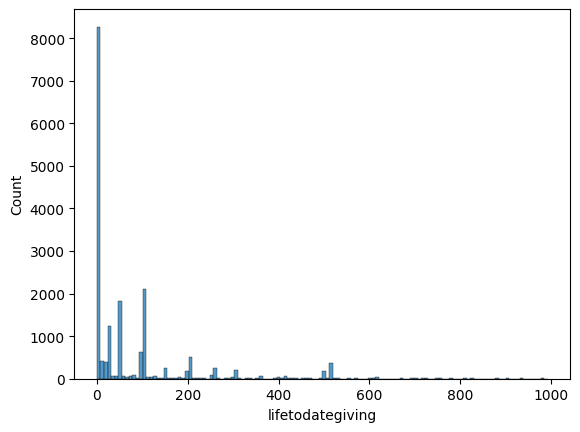

In [12]:
sns.histplot(data=maindata, x='lifetodategiving')

In [13]:
temp = maindata[['lifetodategiving']].value_counts().reset_index()
percentile_0 = (temp.iloc[0, 1]/sum(temp.iloc[:, 1]))
percentile_dist = ((1 - percentile_0) / 4)
# percentiles: 0-45, 45-58.75, 58.75-72.5, 72.5-86.25, 86.25-100
# values: 0, (0, 50], (50, 100], (100-155], 155+ 


#monetary_distribution = [0, 50, 100, 155, np.inf]
monetary_distribution = maindata['lifetodategiving'].quantile(q=[percentile_0, percentile_0 + percentile_dist, percentile_0 + 2*percentile_dist, percentile_0 + 3*percentile_dist, 1.0])
monetary_conditions = [
    (maindata[['lifetodategiving']] == monetary_distribution.iloc[0]),
    (maindata[['lifetodategiving']] > monetary_distribution.iloc[0]) & (maindata[['lifetodategiving']]<= monetary_distribution.iloc[1]),
    (maindata[['lifetodategiving']] > monetary_distribution.iloc[1]) & (maindata[['lifetodategiving']]<= monetary_distribution.iloc[2]),
    (maindata[['lifetodategiving']] > monetary_distribution.iloc[2]) & (maindata[['lifetodategiving']]<= monetary_distribution.iloc[3]),
    (maindata[['lifetodategiving']] > monetary_distribution.iloc[3])
]
values = [1, 2, 3, 4, 5]
maindata['Monetary_Scale'] = np.select(monetary_conditions, values)
maindata['Monetary_Scale'] = maindata['Monetary_Scale'].replace(0, 1)
maindata[['Monetary_Scale', 'lifetodategiving']]
#maindata[['Monetary_Scale']].value_counts()


,Monetary_Scale,lifetodategiving
0,4,140
1,1,0
2,5,517
3,5,511
4,5,511
...,...,...
18447,1,0
18448,1,0
18449,1,0
18450,1,0


# RFM Category Creation

In [14]:
maindata['RFM'] = maindata['Recency_Scale'].astype(str) + maindata['Frequency_Scale'].astype(str) + maindata['Monetary_Scale'].astype(str)
maindata['RFM'] = maindata['RFM'].astype(int)
maindata

,id,times_donated,status,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,ContactType,MonetaryTier,DonorStatus,IndividualDonorType,contactType,Frequency_Scale,Recency_Scale,Monetary_Scale,RFM
0,105f17eb3daf58e488116d96a3c0128f,36.0,unsubscribed,86,10,2,140,0,16,1/11/2021,Donor,Silver,SingleDonor,Multiple Single Donations,Household,3,4,4,434
1,0c672f0542276c45913a18384260ac45,4.0,subscribed,112,16,0,0,0,0,5/7/2020,Donor,Platinum,SingleDonor,Single Donor,Household,1,1,1,111
2,152396c66599907489c97d6657411223,4.0,unsubscribed,10,12,1,517,0,517,5/12/2020,Donor,Platinum,SingleDonor,Single Donor,Household,2,1,5,125
3,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3,5,5,535
4,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3,5,5,535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18447,fc9ddbb138eef602b324492519638b1b,0.0,subscribed,22,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0,1,11
18448,3204ebec76e48072391f8580968ecbfa,0.0,unsubscribed,26,7,0,0,0,0,0,Non-Donor,0,0,0,0,1,0,1,11
18449,5e7b82c3d2e6898e3405d7636d72117d,0.0,subscribed,47,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0,1,11
18450,ef25baad67600715b8cd45ac61473897,0.0,unsubscribed,0,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0,1,11


In [15]:
# less than than 100 = non donor
# low donor, inactive, not recent - likely lost customers
    # recent = 1, 2; frequency = 1, 2; donor = 1, 2
# low donor, inactive, recent - infrequent low donor
    # recent = 3, 4, 5; frequency = 1, 2; donor = 1, 2
# low donor, active, not recent - low donor at risk
    # recent =  1, 2; frequency = 3, 4, 5; donor = 1, 2
# low donot, active, recent - steady low donor
    # recent = 3, 4, 5; frequency = 3, 4, 5; donor = 1, 2
# high donor, inactive, not recent - high donor likely lost
    # recent = 1, 2; frequency = 1, 2; donor = 3, 4, 5;
# high donor, inactive, recent - infrequent high donor
    # recent = 3, 4, 5; frequency = 1, 2; donor = 3, 4, 5
# high donor, active, not recent - high donor at risk
    # recent = 1, 2; frequency = 3, 4, 5; donor = 3, 4, 5
# high donor, active, recent - top customer
    # all 3, 4, 5


In [16]:
# (maindata[["RFM"]] // 100 >= 3) & (maindata[["RFM"]] // 10 % 10 >= 3) & (maindata[["RFM"]] % 10 >= 3)
# #top customer

# (maindata[["RFM"]] // 100 <= 2) & (maindata[["RFM"]] // 10 % 10 >= 3) & (maindata[["RFM"]] % 10 >= 3)
# #high priority customer at risk

# (maindata[["RFM"]] // 100] >= 3) & (maindata[["RFM"]] // 10 % 10 <= 2) & (maindata[["RFM"]] % 10 >= 3)
# # unsteady customer

In [17]:
(maindata[["RFM"]] < 100)
#"Non-donor"

(maindata[["RFM"]] // 100 <= 2) & (maindata[["RFM"]] // 10 % 10 <=2) & (maindata[["RFM"]] % 10 <=2)
# Likely lost customer

(maindata[["RFM"]] // 100 >=3) & (maindata[["RFM"]] // 10 % 10 <=2) & (maindata[["RFM"]] % 10 <=2)
#Customer at risk

,RFM
0,False
1,False
2,False
3,False
4,False
...,...
18447,False
18448,False
18449,False
18450,False


In [18]:
# low donor, active, not recent - customer at risk
(maindata[["RFM"]] // 100 <= 2) & (maindata[["RFM"]] // 10 % 10 >= 3) & (maindata[["RFM"]] % 10 <= 2)
# low donor, active, recent - steady customer
(maindata[["RFM"]] // 100 >= 3) & (maindata[["RFM"]] // 10 % 10 >= 3) & (maindata[["RFM"]] % 10 <= 2)
# high donor, inactive, not recent - high priority customer at risk
(maindata[["RFM"]] // 100 <= 2) & (maindata[["RFM"]] // 10 % 10 <= 2) & (maindata[["RFM"]] % 10 >= 3)


,RFM
0,False
1,False
2,True
3,False
4,False
...,...
18447,False
18448,False
18449,False
18450,False


In [19]:
conditions=[
    (maindata[["RFM"]] < 100),
    (maindata[["RFM"]] // 100 <= 2) & (maindata[["RFM"]] // 10 % 10 <=2) & (maindata[["RFM"]] % 10 <=2),
    (maindata[["RFM"]] // 100 >=3) & (maindata[["RFM"]] // 10 % 10 <=2) & (maindata[["RFM"]] % 10 <=2), #Customer at risk
    (maindata[["RFM"]] // 100 <= 2) & (maindata[["RFM"]] // 10 % 10 >= 3) & (maindata[["RFM"]] % 10 <= 2),
    (maindata[["RFM"]] // 100 >= 3) & (maindata[["RFM"]] // 10 % 10 >= 3) & (maindata[["RFM"]] % 10 <= 2),
    (maindata[["RFM"]] // 100 <= 2) & (maindata[["RFM"]] // 10 % 10 <= 2) & (maindata[["RFM"]] % 10 >= 3),
    (maindata[["RFM"]] // 100 >= 3) & (maindata[["RFM"]] // 10 % 10 >= 3) & (maindata[["RFM"]] % 10 >= 3),
    (maindata[["RFM"]] // 100 <= 2) & (maindata[["RFM"]] // 10 % 10 >= 3) & (maindata[["RFM"]] % 10 >= 3),
    (maindata[["RFM"]] // 100 >= 3) & (maindata[["RFM"]] // 10 % 10 <= 2) & (maindata[["RFM"]] % 10 >= 3)
]
labels = ["Non-donors", "Likely lost customers", "Infrequent low donor", "Low donor at risk", "Steady low donor", "High donor likely lost", "Infrequent high donor", "High donor at risk", "Top Customer"]
maindata["Customer_Category"] = np.select(conditions, labels)
maindata

,id,times_donated,status,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,ContactType,MonetaryTier,DonorStatus,IndividualDonorType,contactType,Frequency_Scale,Recency_Scale,Monetary_Scale,RFM,Customer_Category
0,105f17eb3daf58e488116d96a3c0128f,36.0,unsubscribed,86,10,2,140,0,16,1/11/2021,Donor,Silver,SingleDonor,Multiple Single Donations,Household,3,4,4,434,Infrequent high donor
1,0c672f0542276c45913a18384260ac45,4.0,subscribed,112,16,0,0,0,0,5/7/2020,Donor,Platinum,SingleDonor,Single Donor,Household,1,1,1,111,Likely lost customers
2,152396c66599907489c97d6657411223,4.0,unsubscribed,10,12,1,517,0,517,5/12/2020,Donor,Platinum,SingleDonor,Single Donor,Household,2,1,5,125,High donor likely lost
3,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3,5,5,535,Infrequent high donor
4,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,Donor,Platinum,SingleDonor,Multiple Single Donations,Household,3,5,5,535,Infrequent high donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18447,fc9ddbb138eef602b324492519638b1b,0.0,subscribed,22,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0,1,11,Non-donors
18448,3204ebec76e48072391f8580968ecbfa,0.0,unsubscribed,26,7,0,0,0,0,0,Non-Donor,0,0,0,0,1,0,1,11,Non-donors
18449,5e7b82c3d2e6898e3405d7636d72117d,0.0,subscribed,47,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0,1,11,Non-donors
18450,ef25baad67600715b8cd45ac61473897,0.0,unsubscribed,0,0,0,0,0,0,0,Non-Donor,0,0,0,0,1,0,1,11,Non-donors


In [20]:

np.unique(maindata['Customer_Category']).tolist()

['High donor at risk',
 'High donor likely lost',
 'Infrequent high donor',
 'Infrequent low donor',
 'Likely lost customers',
 'Low donor at risk',
 'Non-donors',
 'Steady low donor',
 'Top Customer']

# 3D Scatter Plot Clustered Visualization

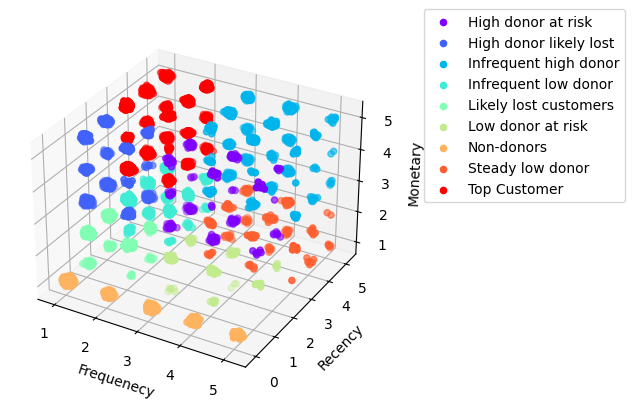

In [21]:
#ignore error messages

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'b']
#colors = [0, 1, 2, 3, 4, 5, 6, 7, 8]

categories = np.unique(maindata['Customer_Category']).tolist()
colors = cm.rainbow(np.linspace(0, 1, len(categories)))

def jitter(values,j):
    return values + np.random.normal(j,0.04,values.shape)

fig = plt.figure()
ax = plt.axes(projection='3d')

for category, c in zip(categories, colors):
    x = jitter(maindata[maindata['Customer_Category'] == category]['Frequency_Scale'], 0.05)
    y = jitter(maindata[maindata['Customer_Category'] == category]['Recency_Scale'], 0.05)
    z = jitter(maindata[maindata['Customer_Category'] == category]['Monetary_Scale'], 0.05)
    ax.scatter(x, y, z, color=c, label=category)

ax.set_xlabel('Frequenecy')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')
plt.legend()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [22]:
maindata['Log_Sends'] = np.log(maindata['Sends'] + 1)
maindata['Log_Opens'] = np.log(maindata['Opens'] + 1)
maindata['Log_Clicks'] = np.log(maindata['Clicks'] + 1)
maindata['Log_yeartodategiving'] = np.log(maindata['yeartodategiving'] + 1)
maindata['Log_lifetodategiving'] = np.log(maindata['lifetodategiving'] + 1)

# K-means Clustering

In [23]:
kdata = maindata[["Log_Clicks", "Log_lifetodategiving"]]
kdata

,Log_Clicks,Log_lifetodategiving
0,1.098612,4.948760
1,0.000000,0.000000
2,0.693147,6.249975
3,1.386294,6.238325
4,1.386294,6.238325
...,...,...
18447,0.000000,0.000000
18448,0.000000,0.000000
18449,0.000000,0.000000
18450,0.000000,0.000000


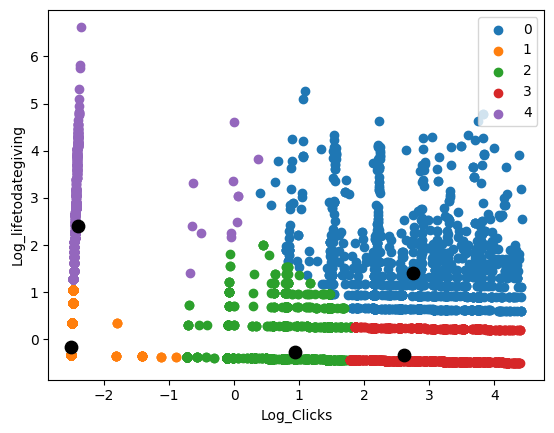

In [24]:
from sklearn.decomposition import PCA
pca = PCA(2)
kmeans = KMeans(5)
kdata = pca.fit_transform(kdata)
label = kmeans.fit_predict(kdata)
unique_labels = np.unique(label)
centroids = kmeans.cluster_centers_
for i in unique_labels:
    plt.scatter(kdata[label == i , 0] , kdata[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.xlabel("Log_Clicks")
plt.ylabel("Log_lifetodategiving")
plt.show()

In [25]:
!pip install statsmodels
import statsmodels.api as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 48.8 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Regression Modeling

In [26]:
X = sm.add_constant(maindata[['Log_Opens', 'Log_Sends']])
Y = maindata['times_donated']
model = sm.OLS(Y, X)
result = model.fit(cov_type = "cluster", cov_kwds = {'groups': maindata[['Customer_Category']]})
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          times_donated   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.439
Date:                Wed, 18 Jan 2023   Prob (F-statistic):              0.293
Time:                        04:41:54   Log-Likelihood:                -68675.
No. Observations:               18452   AIC:                         1.374e+05
Df Residuals:                   18449   BIC:                         1.374e+05
Df Model:                           2                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3751      0.534      0.702      0.482      -0.671       1.422
Log_Opens      0.5727      0.423      1.354      0.176      -0.257       1.402
Log_Sends      0.1330      0.123      1.083      0.279      -0.108       0.374
==============================================================================
Omnibus:                    32532.757   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         35239843.648
Skew:                          12.724   Prob(JB):                         0.00
Kurtosis:                     215.574   Cond. No.                         11.8
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [27]:
clicked = maindata[maindata['Clicks'] > 0]
clicked

,id,times_donated,status,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,...,Frequency_Scale,Recency_Scale,Monetary_Scale,RFM,Customer_Category,Log_Sends,Log_Opens,Log_Clicks,Log_yeartodategiving,Log_lifetodategiving
0,105f17eb3daf58e488116d96a3c0128f,36.0,unsubscribed,86,10,2,140,0,16,1/11/2021,...,3,4,4,434,Infrequent high donor,4.465908,2.397895,1.098612,0.000000,4.948760
2,152396c66599907489c97d6657411223,4.0,unsubscribed,10,12,1,517,0,517,5/12/2020,...,2,1,5,125,High donor likely lost,2.397895,2.564949,0.693147,0.000000,6.249975
3,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,...,3,5,5,535,Infrequent high donor,4.477337,3.295837,1.386294,5.743003,6.238325
4,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,...,3,5,5,535,Infrequent high donor,4.477337,3.295837,1.386294,5.743003,6.238325
8,78e569fa709e3aa0f840ea92f80f3165,16.0,cleaned,66,8,2,517,0,517,2/24/2021,...,3,4,5,435,Infrequent high donor,4.204693,2.197225,1.098612,0.000000,6.249975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18420,6567efc0c2494571ff8c5b4410076b70,0.0,unsubscribed,79,169,5,0,0,0,0,...,4,0,1,41,Non-donors,4.382027,5.135798,1.791759,0.000000,0.000000
18424,cc029402afd0571032feff40f3f23f01,0.0,subscribed,84,65,1,0,0,0,0,...,2,0,1,21,Non-donors,4.442651,4.189655,0.693147,0.000000,0.000000
18437,870dd68b7eb8b65ab2b88a447dc02449,0.0,subscribed,23,60,3,0,0,0,0,...,3,0,1,31,Non-donors,3.178054,4.110874,1.386294,0.000000,0.000000
18438,6f04f1fc63e306ef3abbcc62b8011400,0.0,unsubscribed,79,51,9,0,0,0,0,...,4,0,1,41,Non-donors,4.382027,3.951244,2.302585,0.000000,0.000000


In [28]:
clicked['Donated'] = np.where(clicked['ContactType']== 'Donor', 1, 0)
clicked['Donated'].value_counts()

/tmp/ipykernel_156/488907279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicked['Donated'] = np.where(clicked['ContactType']== 'Donor', 1, 0)


1    3230
0    1961
Name: Donated, dtype: int64

In [29]:
donated_clicked = clicked[clicked["ContactType"]=="Donor"]
donated_clicked

,id,times_donated,status,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,...,Recency_Scale,Monetary_Scale,RFM,Customer_Category,Log_Sends,Log_Opens,Log_Clicks,Log_yeartodategiving,Log_lifetodategiving,Donated
0,105f17eb3daf58e488116d96a3c0128f,36.0,unsubscribed,86,10,2,140,0,16,1/11/2021,...,4,4,434,Infrequent high donor,4.465908,2.397895,1.098612,0.000000,4.948760,1
2,152396c66599907489c97d6657411223,4.0,unsubscribed,10,12,1,517,0,517,5/12/2020,...,1,5,125,High donor likely lost,2.397895,2.564949,0.693147,0.000000,6.249975,1
3,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,...,5,5,535,Infrequent high donor,4.477337,3.295837,1.386294,5.743003,6.238325,1
4,21d59ea01430584a23908d018b94a9c6,54.0,subscribed,87,26,3,511,311,11,7/23/2022,...,5,5,535,Infrequent high donor,4.477337,3.295837,1.386294,5.743003,6.238325,1
8,78e569fa709e3aa0f840ea92f80f3165,16.0,cleaned,66,8,2,517,0,517,2/24/2021,...,4,5,435,Infrequent high donor,4.204693,2.197225,1.098612,0.000000,6.249975,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11042,cbde5f849e5d17f2d6dbcf99a79dea18,1.0,subscribed,111,91,1,103,0,103,5/17/2020,...,1,3,123,High donor likely lost,4.718499,4.521789,0.693147,0.000000,4.644391,1
11046,740e86b554cfbf6ffdd52d77c5c30dff,1.0,subscribed,51,75,3,0,0,0,4/24/2021,...,5,1,531,Steady low donor,3.951244,4.330733,1.386294,0.000000,0.000000,1
11054,499ebc08a96f0fefff2a72fa8757131e,1.0,subscribed,87,2,1,517,0,517,11/26/2020,...,4,5,425,Top Customer,4.477337,1.098612,0.693147,0.000000,6.249975,1
11055,b45a190b3dbfe6c90e0c377d8d1c86ef,3.0,subscribed,114,8,6,155,0,52,12/30/2020,...,4,4,444,Infrequent high donor,4.744932,2.197225,1.945910,0.000000,5.049856,1


In [30]:
one_hot_cols = pd.get_dummies(data=clicked["status"])
clicked = pd.concat([clicked.drop(["status"], axis=1), one_hot_cols], axis=1)
clicked

,id,times_donated,Sends,Opens,Clicks,lifetodategiving,yeartodategiving,lastgiftamount,lastgiftdate,ContactType,...,Customer_Category,Log_Sends,Log_Opens,Log_Clicks,Log_yeartodategiving,Log_lifetodategiving,Donated,cleaned,subscribed,unsubscribed
0,105f17eb3daf58e488116d96a3c0128f,36.0,86,10,2,140,0,16,1/11/2021,Donor,...,Infrequent high donor,4.465908,2.397895,1.098612,0.000000,4.948760,1,0,0,1
2,152396c66599907489c97d6657411223,4.0,10,12,1,517,0,517,5/12/2020,Donor,...,High donor likely lost,2.397895,2.564949,0.693147,0.000000,6.249975,1,0,0,1
3,21d59ea01430584a23908d018b94a9c6,54.0,87,26,3,511,311,11,7/23/2022,Donor,...,Infrequent high donor,4.477337,3.295837,1.386294,5.743003,6.238325,1,0,1,0
4,21d59ea01430584a23908d018b94a9c6,54.0,87,26,3,511,311,11,7/23/2022,Donor,...,Infrequent high donor,4.477337,3.295837,1.386294,5.743003,6.238325,1,0,1,0
8,78e569fa709e3aa0f840ea92f80f3165,16.0,66,8,2,517,0,517,2/24/2021,Donor,...,Infrequent high donor,4.204693,2.197225,1.098612,0.000000,6.249975,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18420,6567efc0c2494571ff8c5b4410076b70,0.0,79,169,5,0,0,0,0,Non-Donor,...,Non-donors,4.382027,5.135798,1.791759,0.000000,0.000000,0,0,0,1
18424,cc029402afd0571032feff40f3f23f01,0.0,84,65,1,0,0,0,0,Non-Donor,...,Non-donors,4.442651,4.189655,0.693147,0.000000,0.000000,0,0,1,0
18437,870dd68b7eb8b65ab2b88a447dc02449,0.0,23,60,3,0,0,0,0,Non-Donor,...,Non-donors,3.178054,4.110874,1.386294,0.000000,0.000000,0,0,1,0
18438,6f04f1fc63e306ef3abbcc62b8011400,0.0,79,51,9,0,0,0,0,Non-Donor,...,Non-donors,4.382027,3.951244,2.302585,0.000000,0.000000,0,0,0,1


In [31]:
X = clicked[['Sends', 'Clicks', 'subscribed', 'unsubscribed']]
y = clicked[['Donated']]
# from imblearn.over_sampling import SMOTE
# os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# columns = X_train.columns

# os_data_X,os_data_y=os.fit_sample(X_train, y_train)
# os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
# os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# from sklearn.feature_selection import RFE

# logreg = LogisticRegression()
# rfe = RFE(logreg, 20)
# rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
(y_test['Donated'] - round(result.predict(X_test))).value_counts()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.628343
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.054     
Dependent Variable: Donated          AIC:              4573.5419 
Date:               2023-01-18 04:41 BIC:              4598.3332 
No. Observations:   3633             Log-Likelihood:   -2282.8   
Df Model:           3                LL-Null:          -2412.8   
Df Residuals:       3629             LLR p-value:      4.4999e-56
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Sends          0.0178    0.0012  14.3143  0.0000   0.0153   0.0202
Clicks        -0.0047    0.0017  -2.8415  0.0045  -0.0080  -0.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e3992b3a-c293-4442-bebc-841151fba7a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>